# Ondřejov Spectra Preprocessing

This work aims to find correct preprocessing techniques for spectral data
from [Ondřejov CCD700 archive][ccd].
These preprocessing method as cleaning, balancing, scaling should help
to increase classification accuracy of a neural network.
Furthermore, it also seek to get more insight into application of machine
learning to spectral data
because there is the [LAMOST spectra survey][lamost]
which contains vast amount of unexplored data of this kind.

[ccd]: http://voarchive.asu.cas.cz/ccd700/q/web/form
[lamost]: http://www.lamost.org/public/?locale=en

The Jupyter notebook is divided into following parts.
Firstly, visualization of spectral data are presented.
Then data cleaning followed by experiments with balancing
and scaling methods.
Meanwhile, all experiments are cross validated using
neural network classifier.

In [1]:
import numpy
import pandas
import seaborn
import imblearn
from matplotlib import pyplot
from sklearn import preprocessing, model_selection
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

In [2]:
seaborn.set_style('ticks')

## Ondřejov Dataset

Ondřejov dataset contains 12936 labeled stellar spectra from
Ondřejov CCD700 archive.
The spectra were observed with Ondřejov Perek 2m Telescope
and the observations were primarily focused on Be stars.

For complete information about the Ondřejov dataset
and corresponding code visit its [GitHub repository][dataset].

[dataset]: https://github.com/podondra/ondrejov-dataset

In [3]:
spectra = pandas.read_csv('ondrejov-dataset.csv', index_col='id')
spectra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12936 entries, a201305230017 to we200016
Columns: 151 entries, dec to 6732.0
dtypes: float64(142), int64(2), object(7)
memory usage: 15.0+ MB


### Metadata

The dataset contains some metadata from which the most interesting is
the *label* attribute:

- *id*: unique identifier (FITS file name)
- *label*: assigned class
- *object*: title of observation
- *ra*: right ascension
- *dec*: declination
- *expval*: exposure value in photon counts (Mcounts)
- *gratang*: diffraction grating angle
- *detector*: name of the detector
- *chipid*: name of CCD chip
- *specfilt*: spectral filter
- *date-obs*: UTC date start of observation
- *dichmir*: dichroic mirror number

In [4]:
spectra.iloc[:, :11].head()

,dec,gratang,detector,expval,object,dichmir,chipid,ra,specfilt,label,date-obs
id,,,,,,,,,,,
a201305230017,-11:09:40.70,30.25,PyLoN 2048x512BX,19.246130,alp Vir,2,E2V 42-10 BX,13:25:11.580,1,absorption,2013-05-23
a201306060015,+19:10:56.60,30.25,PyLoN 2048x512BX,0.009187,alp Boo,2,E2V 42-10 BX,14:15:39.667,1,absorption,2013-06-06
a201306060016,+19:10:56.60,30.25,PyLoN 2048x512BX,0.012332,alp Boo,2,E2V 42-10 BX,14:15:39.667,1,absorption,2013-06-06
a201306060018,+33:21:45.60,30.25,PyLoN 2048x512BX,5.056532,beta Lyr,2,E2V 42-10 BX,18:50:04.787,1,emission,2013-06-06
a201306060019,+33:21:45.60,30.25,PyLoN 2048x512BX,15.040130,beta Lyr,2,E2V 42-10 BX,18:50:04.787,1,emission,2013-06-06


### Labels

Spectra are divided into 3 classes according to profile of
the [H-alpha spectral line][halpha].

[halpha]: https://en.wikipedia.org/wiki/H-alpha

For better processing the label strings are converted to numerical
value in range from 0 to 2.

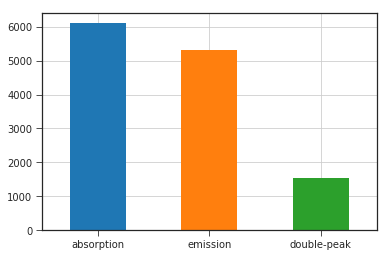

In [5]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(spectra['label'])
spectra['label'].value_counts().plot.bar(rot=0, grid=True)

### Spectral Data

Rest of dataset columns are the flux values for each spectrum.
There is exactly 140 measurement for each spectrum.
While experimenting with the dataset these column are the one
to which preprocessing method should be applied.
Therefore, the design matrix $X$ is created from them 

In [6]:
X = spectra.iloc[:, 11:].as_matrix()
X.shape

(12936, 140)

## Data Visualization

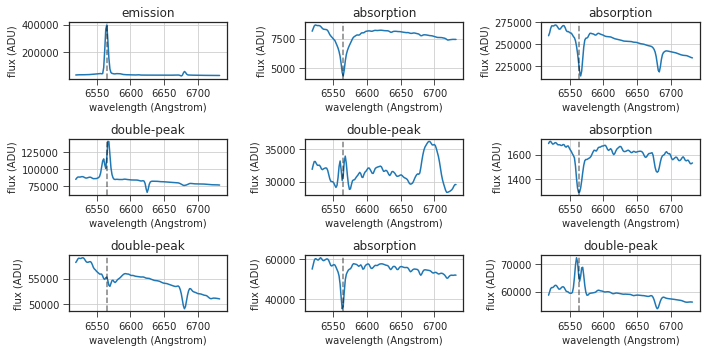

In [7]:
# http://classic.sdss.org/dr7/products/spectra/vacwavelength.html
HALPHA = 6564.614
# waveleghts from https://github.com/podondra/ondrejov-dataset
WAVES = numpy.linspace(6519, 6732, 140)

def plot_flux(flux, title=None, ax=None):
    if ax is None:
        ax = pyplot.subplot()

    ax.plot(WAVES, flux)
    ax.set_ylabel('flux (ADU)')
    ax.set_xlabel('wavelength (Angstrom)')
    ax.axvline(HALPHA, color='black', linestyle='dashed', alpha=0.5)
    ax.grid()
    
    if title is not None:
        ax.set_title(title)

nrows = 3
ncols = 3
n_idxs = nrows * ncols
rnd_idxs = numpy.random.choice(len(X), size=n_idxs, replace=False)
f, axes = pyplot.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
for ax, idx in zip(axes.flat, rnd_idxs):
    plot_flux(X[idx], title=spectra.iloc[idx]['label'], ax=ax)
f.tight_layout()

### PCA

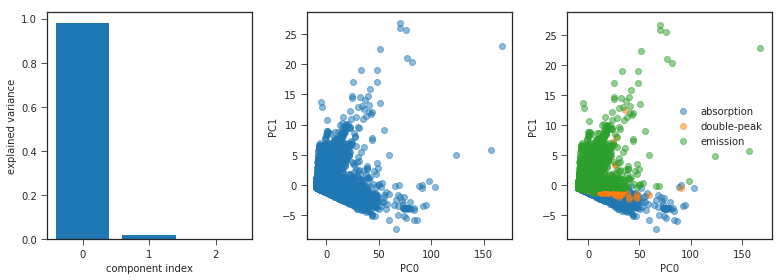

In [8]:
def plot_pca(X_pca):
    f, (ax1, ax2, ax3) = pyplot.subplots(ncols=3, figsize=(11, 4))

    ax1.bar(numpy.arange(pca.n_components_), pca.explained_variance_ratio_)
    ax1.set_xlabel('component index')
    ax1.set_ylabel('explained variance')

    ax2.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)

    for label, cls in enumerate(le.classes_):
        ax3.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=cls, alpha=0.5)
    ax3.legend()

    for ax in ax2, ax3:
        ax.set_xlabel('PC0')
        ax.set_ylabel('PC1')

    f.tight_layout()

pca = PCA(n_components=3)
plot_pca(pca.fit_transform(preprocessing.scale(X, axis=0)))

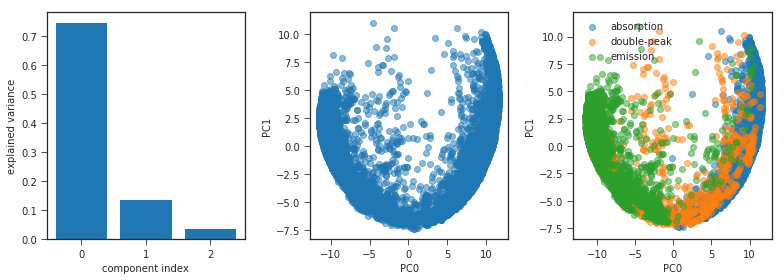

In [9]:
pca = PCA(n_components=3)
plot_pca(pca.fit_transform(preprocessing.scale(X, axis=1)))

### t-SNE

### LDA

## Data Cleaning

## Neural Network

### Train and Test Split

Text(0.5,1,'test set')

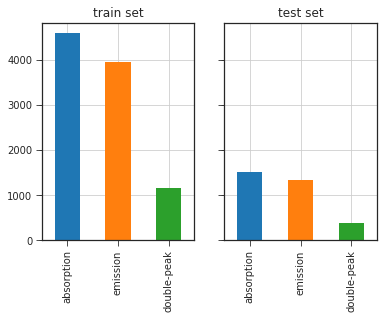

In [10]:
X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X, y)
f, (ax1, ax2) = pyplot.subplots(ncols=2, sharey=True)
pandas.Series(le.inverse_transform(y_tr)).value_counts().plot.bar(grid=True, ax=ax1)
ax1.set_title('train set')
pandas.Series(le.inverse_transform(y_te)).value_counts().plot.bar(grid=True, ax=ax2)
ax2.set_title('test set')

In [11]:
mpl = MLPClassifier()
accuracies = model_selection.cross_val_score(mpl, X_tr, y_tr, cv=5, n_jobs=-1)
accuracies.mean(), accuracies.std()

(0.83425270538003871, 0.044047892879516139)

## Balancing and Scaling